# Chest X Ray Pulmonary Diagnoses using DenseNet for Indian data
## 4A Semester project, Mahindra University
### Dipyaman Roy, Suchir R Punuru

---

### Consolidate dataset into one directory ⚠️
Since data for the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) was collected in batches, they were sorted into a directory per batch. This may be cumbersome to handle, hence the following code consolidates the images into one directory.

⚠️ <span style="color:red">Execute only once on CXR8 `data/` folder. Skip to next cell if you have already executed it once.</span>

In [ ]:
import os
import shutil

def copy_png_images(source_dir, destination_dir):
    # Ensure the destination directory exists
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Walk through the source directory and its subdirectories
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith('.png'):
                # Construct the full file path
                full_file_path = os.path.join(root, file)
                
                # Construct the destination path
                destination_path = os.path.join(destination_dir, file)
                
                # Copy the file to the destination directory
                shutil.copy2(full_file_path, destination_path)
                print(f"Copied: {full_file_path} -> {destination_path}")

if __name__ == "__main__":
    # Specify the source directory (where to look for .png files)
    source_directory = "data/CXR8/images"
    
    # Specify the destination directory (where to copy the .png files)
    destination_directory = "data/CXR8/all_images"
    
    # Call the function to copy the .png files
    copy_png_images(source_directory, destination_directory)

## Imports

In [4]:
# Import necessary packages

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures to be drawn.
plt.rcParams['figure.figsize'] = [10, 7]

In [5]:
# Check if PyTorch is using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



## Data Exploration
Getting familiarized with chest x-ray images taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315). The following are using the images classified with methods outlined in [Holste et al. (2023)](https://arxiv.org/abs/2308.09180). 

In [6]:
# Read csv file containing training data
train_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_train.csv")
valid_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_val.csv")
test_df = pd.read_csv("data/CXR8/PruneCXR/miccai2023_nih-cxr-lt_labels_test.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 78506 rows and 22 columns in the train data frame


,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [7]:
print(f"Train set: The total subject ids are {train_df['subj_id'].count()}, from those the unique ids are {train_df['subj_id'].value_counts().shape[0]} ")
print(f"Validation set: The total subject ids are {valid_df['subj_id'].count()}")
print(f"Test set: The total subject ids are {test_df['subj_id'].count()}")

Train set: The total subject ids are 78506, from those the unique ids are 24507 
Validation set: The total subject ids are 12533
Test set: The total subject ids are 21081


### Preventing Data Leakage
It is worth noting that our dataset contains multiple images for each patient. This could be the case, for example, when a patient has taken multiple X-ray images at different times during their hospital visits. In our data splitting, we have ensured that the split is done on the patient level so that there is no data "leakage" between the train, validation, and test datasets.

In [8]:
def check_for_leakage(df1, df2, subj_col):
    """
    Return True if there any subjects are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        subj_col (str): string name of column with subject IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_subjects_unique = set(df1['subj_id'])
    df2_subjects_unique = set(df2['subj_id'])
    
    subjects_in_both_groups = list(df1_subjects_unique.intersection(df2_subjects_unique))

    # leakage contains true if there is subject overlap, otherwise false.
    leakage = len(subjects_in_both_groups) > 0 
        
    return leakage

In [9]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'subj_id')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'subj_id')))

leakage between train and test: False
leakage between valid and test: False


### Explore data labels
Create a list of the names of each patient condition or disease. 

In [10]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subj_id']


In [11]:
# Remove unnecesary elements
columns.remove('id')
columns.remove('subj_id')

# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

There are 20 columns of labels for these conditions: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding']
The class Atelectasis has 7587 samples
The class Cardiomegaly has 1590 samples
The class Consolidation has 2626 samples
The class Edema has 1283 samples
The class Effusion has 7919 samples
The class Emphysema has 1327 samples
The class Fibrosis has 1138 samples
The class Hernia has 130 samples
The class Infiltration has 12739 samples
The class Mass has 3689 samples
The class Nodule has 4359 samples
The class Pleural Thickening has 1998 samples
The class Pneumonia has 806 samples
The class Pneumothorax has 2432 samples
The class Pneumoperitoneum has 214 samples
The class Pneumomediastinum has 88 samples
The class Subcutan

### Data Visualization
Using the image names listed in the csv file, retrieving the image associated with each row of data in the train dataframe. 

Display Random Images


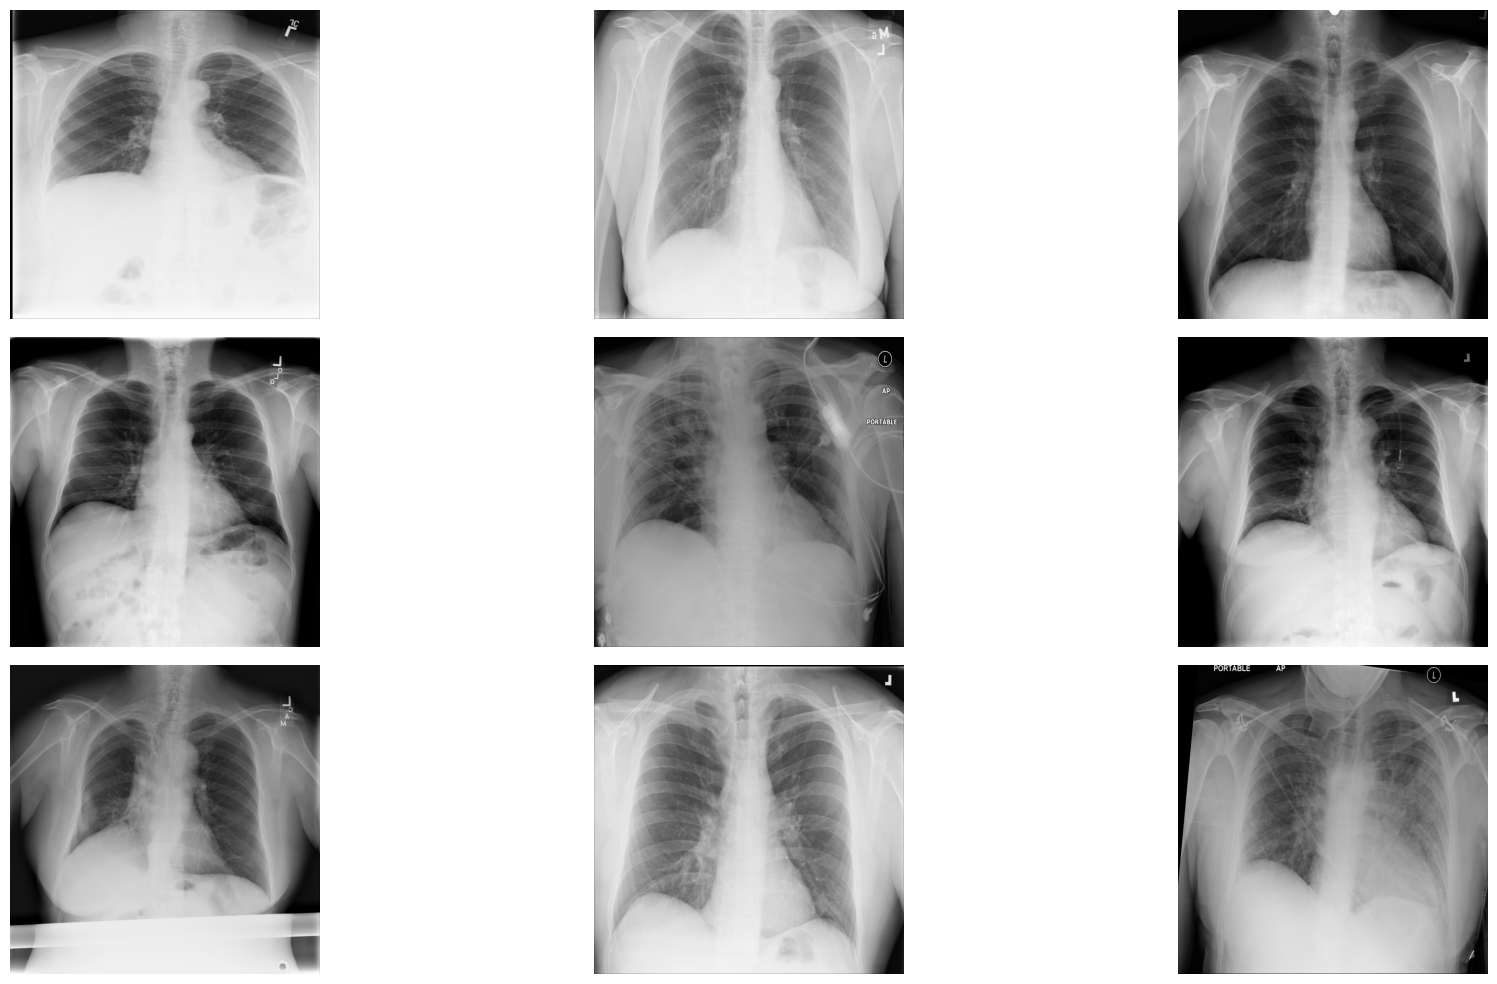

In [12]:
# Location of the image dir
img_dir = 'data/CXR8/all_images'

"""
# Create a dictionary mapping image names to their full paths
image_paths = {}
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file.endswith('.png'):
            image_paths[file] = os.path.join(root, file)
"""
# Extract image file names from the dataframe's 'id' column
images = train_df['id'].values

# Randomly select 9 image file names from the dataframe
random_images = [np.random.choice(images) for i in range(9)]

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20, 10))

# Iterate and plot the random images by finding their corresponding paths
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    """
    # Check if image path exists in the dictionary
    if img_path:
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    """

# Adjust subplot parameters to give specified padding
plt.tight_layout()

### Investigate a single image
Looking at the first image in the dataset and printing out some details of the image contents.

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.5025 and the standard deviation is 0.2644


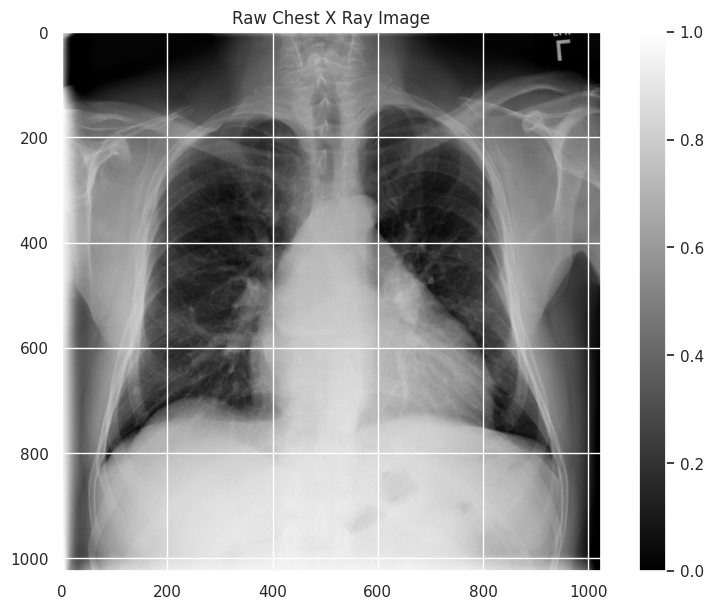

In [13]:
# Get the first image listed in the train_df dataframe
sample_img = train_df.id[0]

# Initialize a variable to store the full path of the first encountered image
raw_image = plt.imread(os.path.join(img_dir, sample_img))

"""
# Traverse through all subdirectories in img_dir to find the first match
for root, dirs, files in os.walk(img_dir):
    for file in files:
        if file == sample_img:  
            raw_image_path = os.path.join(root, file)
            break
    if raw_image_path:  
        break

# Load and display the image if found
if raw_image_path:
    raw_image = plt.imread(raw_image_path)
    plt.imshow(raw_image, cmap='gray')
    plt.grid(color='w', linestyle='-', linewidth=1)
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')
else:
    print(f"Image {sample_img} not found.")
"""

plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

### Investigate pixel value distribution
Plotting the distribution of pixel values in the image shown above. 

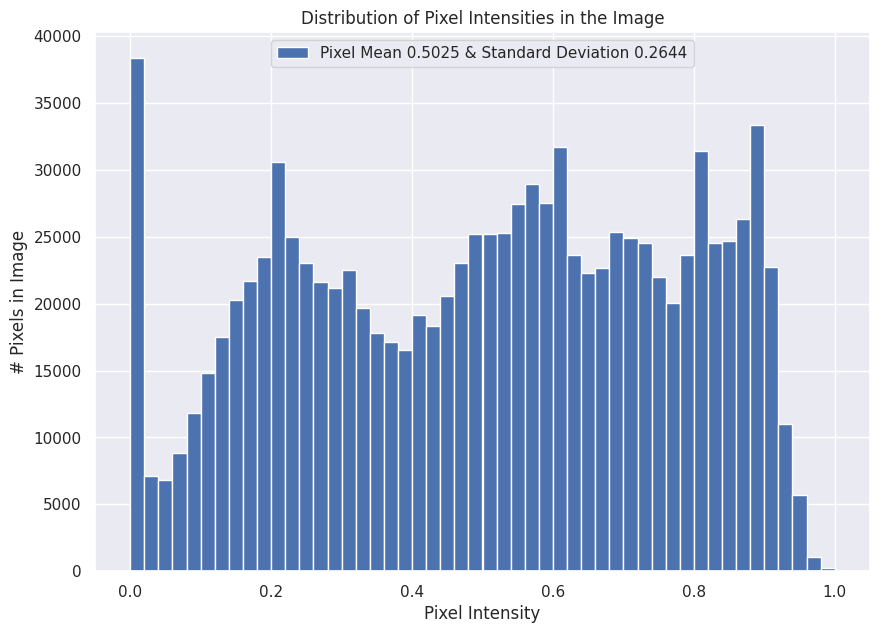

In [14]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

## Image Preprocessing in Keras
### Standardization

Normalizing images is better suited for training a convolutional neural network. For this task we use the Keras [ImageDataGenerator](https://keras.io/preprocessing/image/) function to perform data preprocessing and data augmentation.
The `image_generator` will adjust the image data such that the new mean of the data will be zero, and the standard deviation of the data will be 1.  

In other words, the generator will replace each pixel value in the image with a new value calculated by subtracting the mean and dividing by the standard deviation.

$$\frac{x_i - \mu}{\sigma}$$

Creating an image generator for preprocessing. Pre-process the data using the `image_generator`as well as reduce the image size down to 320x320 pixels.

In [15]:
class CustomImageDataset(Dataset):
    def __init__(self, df, image_dir, x_col, y_cols, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.x_col = x_col
        self.y_cols = y_cols
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx][self.x_col]
        img_path = f"{self.image_dir}/{img_name}"
        image = Image.open(img_path).convert('RGB')
        labels = self.df.iloc[idx][self.y_cols].values.astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, labels

In [19]:
def get_train_generator(df, image_dir, x_col, y_cols, batch_size=8, target_w=320, target_h=320):
    """
    Return generator for training set, normalizing using batch statistics.

    Args:
      df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataLoader): iterator over training set
    """        
    print("getting train generator...")
    
    # Define transformations for the training set
    transform = transforms.Compose([
        transforms.Resize((target_w, target_h)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x - x.mean()) / x.std())  # Samplewise normalization
    ])
    
    # Create dataset and dataloader
    dataset = CustomImageDataset(df, image_dir, x_col, y_cols, transform=transform)
    train_generator = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return train_generator

In [20]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, 
                                 target_w=320, target_h=320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataLoader) and valid_generator: iterators over test set and validation set respectively
    """
    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")
    
    # Define transformations for the training set
    transform = transforms.Compose([
        transforms.Resize((target_w, target_h)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x - x.mean()) / x.std())  # Samplewise normalization
    ])
    
    print("\ngetting valid generator...")
    valid_dataset = CustomImageDataset(valid_df, image_dir, x_col, y_cols, transform=transform)
    valid_generator = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    print("\ngetting test generator...")
    test_dataset = CustomImageDataset(test_df, image_dir, x_col, y_cols, transform=transform)
    test_generator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return valid_generator, test_generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


getting train generator...

extracting 100 train images to normalize validation and test datasets...

getting valid generator...

getting test generator...
The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.5712 and the minimum is -4.2203
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


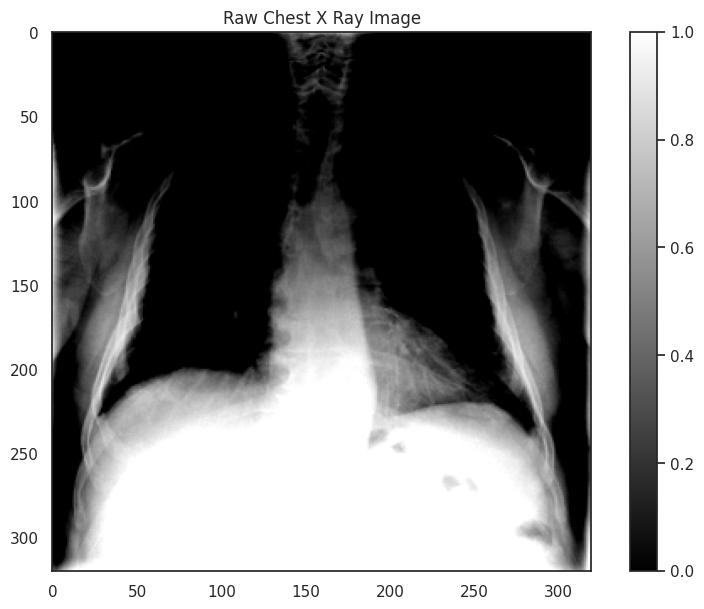

In [21]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
          'Pneumothorax', 'Pleural Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']
IMAGE_DIR = "data/CXR8/all_images"

# Assuming train_df, valid_df, and test_df are already defined
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "id", labels)

# Plot a processed image
sns.set_style("white")
generated_image, label = next(iter(train_generator))
plt.imshow(generated_image[0].permute(1, 2, 0).numpy(), cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[2]} pixels width and {generated_image.shape[3]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

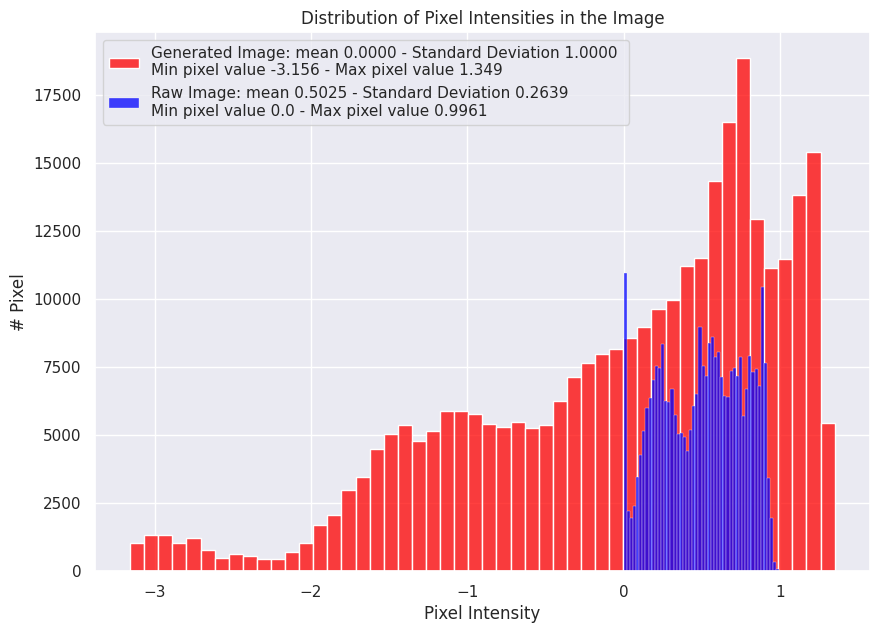

In [45]:
# Load and process the raw image
raw_image_path = f"{IMAGE_DIR}/{train_df.iloc[0]['id']}"
raw_image = Image.open(raw_image_path).convert('RGB')
raw_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor()
])
raw_image = raw_transform(raw_image).numpy()

# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for generated image
sns.histplot(generated_image[0].numpy().ravel(), 
             label=f'Generated Image: mean {np.mean(generated_image[0].numpy()):.4f} - Standard Deviation {np.std(generated_image[0].numpy()):.4f} \n'
             f'Min pixel value {np.min(generated_image[0].numpy()):.4} - Max pixel value {np.max(generated_image[0].numpy()):.4}', 
             color='red', 
             kde=False, 
             bins=50)

# Plot histogram for raw image
sns.histplot(raw_image.ravel(), 
             label=f'Raw Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n'
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}', 
             color='blue', 
             kde=False, 
             bins=50)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

### Addressing Class Imbalance with Weighted Loss
One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets. Here is the plot the frequency of each of the labels in our dataset.

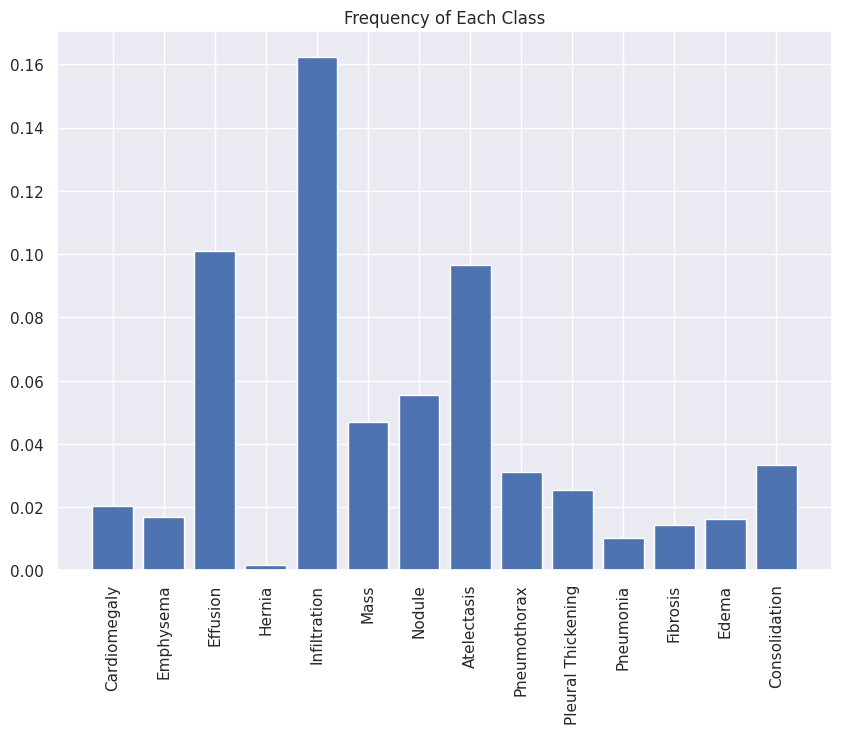

In [19]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can see from this plot that the prevalance of positive cases varies significantly across the different pathologies. 

* The `Hernia` pathology has the greatest imbalance with the proportion of positive training cases being about 0.2%. 
* But even the `Infiltration` pathology, which has the least amount of imbalance, has only 17.5% of the training cases labelled positive.

Ideally, we would train our model using an evenly balanced dataset so that the positive and negative training cases would contribute equally to the loss. 

#### Impact of class imbalance on loss function

Let's take a closer look at this. Assume we would have used a normal cross-entropy loss for each pathology. We recall that the cross-entropy loss contribution from the $i^{th}$ training data case is:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

where $x_i$ and $y_i$ are the input features and the label, and $f(x_i)$ is the output of the model, i.e. the probability that it is positive. 

Note that for any training case, either $y_i=0$ or else $(1-y_i)=0$, so only one of these terms contributes to the loss (the other term is multiplied by zero, and becomes zero). 

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$

Using this formulation, we can see that if there is a large imbalance with very few positive training cases, for example, then the loss will be dominated by the negative class. Summing the contribution over all the training cases for each class (i.e. pathological condition), we see that the contribution of each class (i.e. positive or negative) is: 

$$freq_{p} = \frac{\text{number of positive examples}}{N} $$

$$\text{and}$$

$$freq_{n} = \frac{\text{number of negative examples}}{N}.$$

### Computing Class Frequencies

In [20]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    return positive_frequencies, negative_frequencies

In [21]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02025323, 0.01690317, 0.10087127, 0.00165592, 0.16226785,
       0.04699004, 0.05552442, 0.09664229, 0.03097852, 0.02545028,
       0.01026673, 0.01449571, 0.0163427 , 0.03344967])

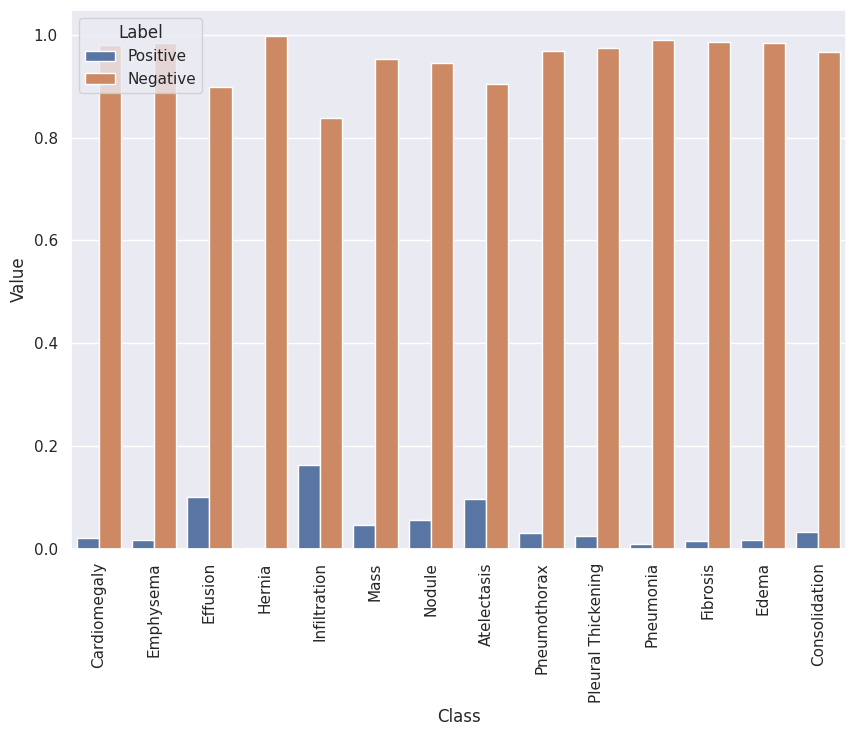

In [22]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])
data = pd.concat([data, neg_data], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

The contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [23]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Let's verify this by graphing the two contributions next to each other:

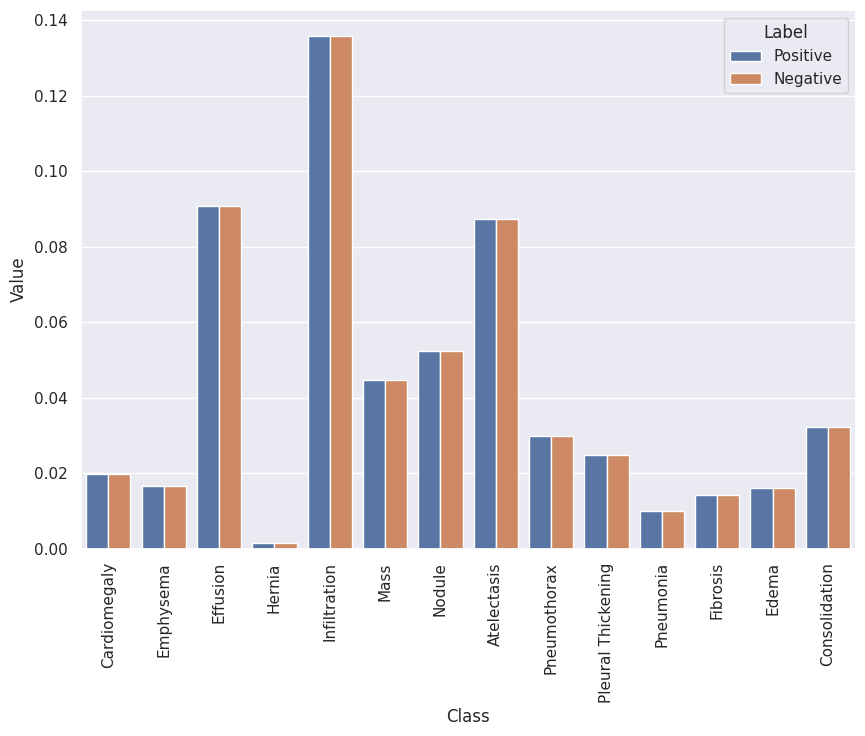

In [24]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
neg_data = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])
data = pd.concat([data, neg_data], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

### Weighted Loss

In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += - pos_weights[i] * K.mean(y_true[:,i] * K.log(y_pred[:,i] + epsilon)) \
            - neg_weights[i] * K.mean((1-y_true[:,i]) * K.log(1-y_pred[:,i] + epsilon)) 
        return loss

    return weighted_loss             # this is a function taking 2 arguments y_true and y_pred

## DenseNet121
Using the pre-trained [DenseNet121](https://www.kaggle.com/pytorch/densenet121) model.Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network
- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is connected to the 3rd, 4th, 5th etc.

Gao Huang et al. (2018), [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

<img src="https://miro.medium.com/v2/resize:fit:678/1*u4hyohOF9SIRRLBAzqYXfQ.jpeg" alt="U-net Image" width="400" align="middle"/>

We can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction logits for each of our classes.

In [26]:
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.preprocessing import image

def load_C3M3_model():
    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    print("Got loss weights")
    
    # Create the base pre-trained model
    base_model = DenseNet121(weights='densenet.hdf5', include_top=False)
    print("Loaded DenseNet")
    
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer='adam', loss=get_weighted_loss(neg_weights, pos_weights))
    print("Compiled Model")

    model.load_weights("data/pretrained_model.h5")
    print("Loaded Weights")
    return model

In [ ]:
model = load_C3M3_model()